In [2]:
import pandas as pd
import numpy as np

# Load training data; use sep=r'\s+' because columns are space-separated
train_df = pd.read_csv('train_FD001.txt', sep=r'\s+', header=None)

# Define column names based on NASA documentation
col_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3'] + [f's{i}' for i in range(1, 22)]
train_df.columns = col_names

# Sort by engine ID and then time cycle to ensure chronological order
train_df = train_df.sort_values(['id', 'cycle'])


In [3]:
train_df.head

<bound method NDFrame.head of         id  cycle  setting1  setting2  setting3      s1      s2       s3  \
0        1      1   -0.0007   -0.0004     100.0  518.67  641.82  1589.70   
1        1      2    0.0019   -0.0003     100.0  518.67  642.15  1591.82   
2        1      3   -0.0043    0.0003     100.0  518.67  642.35  1587.99   
3        1      4    0.0007    0.0000     100.0  518.67  642.35  1582.79   
4        1      5   -0.0019   -0.0002     100.0  518.67  642.37  1582.85   
...    ...    ...       ...       ...       ...     ...     ...      ...   
20626  100    196   -0.0004   -0.0003     100.0  518.67  643.49  1597.98   
20627  100    197   -0.0016   -0.0005     100.0  518.67  643.54  1604.50   
20628  100    198    0.0004    0.0000     100.0  518.67  643.42  1602.46   
20629  100    199   -0.0011    0.0003     100.0  518.67  643.23  1605.26   
20630  100    200   -0.0032   -0.0005     100.0  518.67  643.85  1600.38   

            s4     s5  ...     s12      s13      s14     

In [4]:
# Calculate max cycle for each engine
max_cycle = train_df.groupby('id')['cycle'].max().reset_index()
max_cycle.columns = ['id', 'max']

# Merge back and calculate RUL
train_df = train_df.merge(max_cycle, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']

# Drop the 'max' column as it's no longer needed
train_df.drop('max', axis=1, inplace=True)


In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


# Define the sensors we want to smooth
sensor_cols = [f's{i}' for i in range(1, 22)]

# Create a window size for rolling
window_size = 5

# Calculate Rolling Mean and Std Dev for each engine (id) separately
# I used groupby('id') so the average doesn't bleed from one engine to the next
for col in sensor_cols:
    # Calculate Rolling Mean
    train_df[f'{col}_rolling_mean'] = train_df.groupby('id')[col].transform(lambda x: x.rolling(window=window_size).mean())
    
    # Calculate Rolling Standard Deviation (captures increasing volatility/vibration)
    train_df[f'{col}_rolling_std'] = train_df.groupby('id')[col].transform(lambda x: x.rolling(window=window_size).std())

train_df = train_df.bfill()

print(train_df.head(10))




   id  cycle  setting1  setting2  setting3      s1      s2       s3       s4  \
0   1      1   -0.0007   -0.0004     100.0  518.67  641.82  1589.70  1400.60   
1   1      2    0.0019   -0.0003     100.0  518.67  642.15  1591.82  1403.14   
2   1      3   -0.0043    0.0003     100.0  518.67  642.35  1587.99  1404.20   
3   1      4    0.0007    0.0000     100.0  518.67  642.35  1582.79  1401.87   
4   1      5   -0.0019   -0.0002     100.0  518.67  642.37  1582.85  1406.22   
5   1      6   -0.0043   -0.0001     100.0  518.67  642.10  1584.47  1398.37   
6   1      7    0.0010    0.0001     100.0  518.67  642.48  1592.32  1397.77   
7   1      8   -0.0034    0.0003     100.0  518.67  642.56  1582.96  1400.97   
8   1      9    0.0008    0.0001     100.0  518.67  642.12  1590.98  1394.80   
9   1     10   -0.0033    0.0001     100.0  518.67  641.71  1591.24  1400.46   

      s5  ...  s17_rolling_mean  s17_rolling_std  s18_rolling_mean  \
0  14.62  ...             391.8         1.095445 

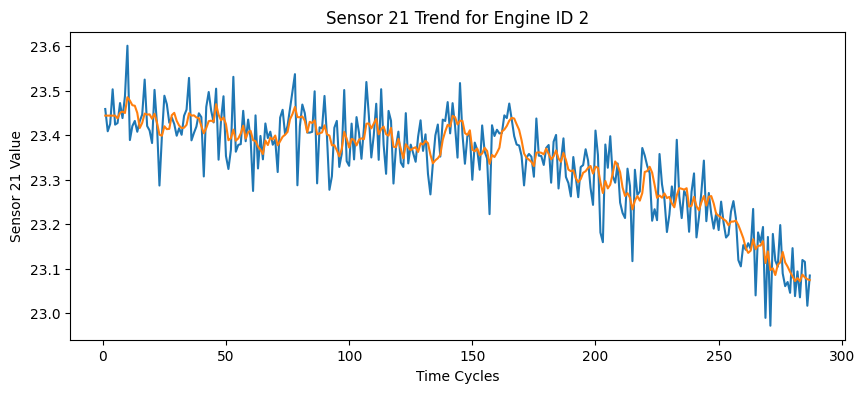

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot sensor 21 (s21) and its rolling mean for the second engine to see the degradation trend
plt.figure(figsize=(10, 4))
plt.plot(train_df[train_df['id'] == 2]['cycle'], train_df[train_df['id'] == 2]['s21'])
plt.plot(train_df[train_df['id'] == 2]['cycle'], train_df[train_df['id'] == 2]['s21_rolling_mean'])
plt.xlabel('Time Cycles')
plt.ylabel('Sensor 21 Value')
plt.title('Sensor 21 Trend for Engine ID 2')
plt.show()

In [7]:
# Define features (X) and target (y)
features = ['setting1', 'setting2', 'setting3']  + [f's{i}_rolling_mean' for i in range(1, 22)]  + [f's{i}_rolling_std' for i in range(1, 22)]
# + [f's{i}' for i in range(1, 22)]
X = train_df[features]
y = train_df['RUL']

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Initialise and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

In [12]:
from sklearn.metrics import mean_squared_error

# Predict on validation data
y_pred = model.predict(X_val)
y_pred_rounded = np.round(y_pred).astype(int)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_pred_rounded))
print(f'Validation RMSE: {rmse:.2f} cycles')

Validation RMSE: 31.42 cycles


In [14]:
# Get importance scores
importances = model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for visualization
forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)


In [16]:
print(forest_importances)

s4_rolling_mean     0.468407
s9_rolling_mean     0.090068
s21_rolling_mean    0.073963
s11_rolling_mean    0.055059
s14_rolling_mean    0.032539
s7_rolling_mean     0.018498
s12_rolling_mean    0.017061
s15_rolling_mean    0.014343
s2_rolling_mean     0.014055
s8_rolling_mean     0.013981
s3_rolling_mean     0.013542
s13_rolling_mean    0.013016
s20_rolling_mean    0.012790
s14_rolling_std     0.012019
s21_rolling_std     0.011597
s12_rolling_std     0.011351
s7_rolling_std      0.011342
s11_rolling_std     0.011256
s15_rolling_std     0.011207
s3_rolling_std      0.011001
s4_rolling_std      0.010461
s13_rolling_std     0.010430
s9_rolling_std      0.010344
s8_rolling_std      0.009880
s20_rolling_std     0.009700
s2_rolling_std      0.009614
s17_rolling_std     0.006887
s17_rolling_mean    0.005944
setting1            0.005547
setting2            0.003223
s6_rolling_std      0.000463
s6_rolling_mean     0.000412
s1_rolling_mean     0.000000
s10_rolling_mean    0.000000
s5_rolling_mea